# BERTopic - Tutorial
We start with installing bertopic from pypi before preparing the data. 

**NOTE**: Make sure to select a GPU runtime. Otherwise, the model can take quite some time to create the document embeddings!

In [ ]:
# need this code snippet in each notebook to mount the google drive
from google.colab import drive  
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!pip install bertopic

# Prepare data
For this example, we use the famous 20 Newsgroups dataset which contains roughly 18000 newsgroups posts on 20 topics.

In [ ]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers.advanced_activations import PReLU, LeakyReLU
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import pickle
from sklearn.externals import joblib
 
#docs = fetch_20newsgroups(subset='train')['data'] # docs is a flat list with each doc as an item in the list

In [ ]:
os.chdir("/content/gdrive/My Drive/20191101-2020-1031-alerts/python")
!ls

 autoencoder_classifier.h5  'processminer-rare-event-mts - data.csv'
 BerTopic.py		     __pycache__
 embeddings2.joblib	     topic-model-example
 embeddings2.pkl	     training.pdf
 embeddings4.joblib	     weights.best.hdf5
 embeddings.pkl		     y_encoded2.joblib
 frame.csv		     y_encoded4.joblib
 logs			     y_encoded4_multi.joblib
 Netflow_NN.py		     y_encoded.joblib
 process_alerts.py


In [ ]:
# break large file into chunks and process each chunk
fields =['message','labelName']
for df_alerts in pd.read_csv("frame.csv", iterator=True, chunksize=15000000,usecols=fields,low_memory=False):
    break 
df_alerts.shape

(15000000, 2)

In [ ]:
df=pd.read_csv("../2019-11-02-alerts.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (13,14,15,17) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
list(df.columns)

['tenant',
 'alertDate',
 'uuid',
 'alert_type',
 'severity',
 'creator',
 'message',
 'eventTimestamp',
 'ingestDelay',
 'alertTimestamp',
 'insertDelay',
 'insertTimestamp',
 'labelDelay',
 'labelTimestamp',
 'labelName',
 'labelUser',
 'labelBulk',
 'investigateId']

In [ ]:
df_alerts.columns =['text','target']
df_alerts = df_alerts.dropna()
df_alerts.head()

,text,target
0,53285 VID14156 Suspicious powershell.exe in HT...,true positive: benign
1,50192 VID59478 SSLv3 Large Heartbeat Content D...,true positive: benign
6,A process using Force Data Execution Preventio...,true positive: benign
10,A process using Force Data Execution Preventio...,true positive: benign
11,A process using Force Data Execution Preventio...,false positive


In [ ]:
docs = df_alerts['text'].tolist()
len(docs)

4595254

In [ ]:
# Python program to Remove all  digits from a list of string 
import re 
docs = df_alerts['text'].tolist()  

def remove(list):
    try: 
       pattern = '[0-9]'
       list = [re.sub(pattern, '', i) for i in list] 
       pattern = 'VID'
       list = [re.sub(pattern, '', i) for i in list]
    except:
       return list 
    return list

# now purge digits from alerts
docs = remove(docs)
df_alerts.text = docs

In [ ]:
target = df_alerts['target'].tolist()
set(target)

{'false positive',
 'false-positive',
 'not actionable',
 'not-actionable',
 'true positive',
 'true positive: benign',
 'true positive: malicious',
 'true-positive-benign',
 'true-positive-malicious'}

In [ ]:
df_alerts = df_alerts[df_alerts['target'] != 'false positive']
df_alerts = df_alerts[df_alerts['target'] != 'false-positive']
df_alerts = df_alerts[df_alerts['target'] != 'not actionable']
df_alerts = df_alerts[df_alerts['target'] != 'not-actionable']
df_alerts = df_alerts[df_alerts['target'] != 'true positive']

In [ ]:
set(df_alerts.target)

{'true positive: benign',
 'true positive: malicious',
 'true-positive-benign',
 'true-positive-malicious'}

In [ ]:
# Fraction of malicious alerts to labelled corpus
sum('malicious' in s for s in target)/len(target)

0.005568571399970491

In [ ]:
# map targets to numberic
def binary_classes(t):
  if t == 'true positive: malicious' or t == 'true-positive-malicious':
     return 1
  #elif t == 'true positive: malicious' or t == 'true-positive-malicious':
  #  return 1
  else:
    return 0

def multi_classes(t):
   if t == 'false positive' or t == 'false-positive':
     return 0
   elif t == 'true positive: benign' or t == 'true-positive-benign':
     return 1
   elif t == 'not actionable' or t == 'not-actionable':
     return 2
   else:  #t == 'true positive: malicious' or t == 'true-positive-malicious':
    return 3

In [ ]:
Class = 2    # flag for choosing between binary =1/multiclass=0 classifier
if Class == 2:
  y = [binary_classes(x) for x in target]
else:
  y = [multi_classes(x) for x in target]

from sklearn.preprocessing import OneHotEncoder
print('Vectorizing Y labels...')
y=np.array(y)
y_encoded = to_categorical(y)
# invert encoding
#inverted = argmax(encoded[0])
#print(inverted)

Vectorizing Y labels...


In [ ]:
y_encoded

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
len(set(y))

2

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/
# https://www.sbert.net/
# https://stackabuse.com/reading-and-writing-lists-to-a-file-in-python/
run_again = 1
if os.path.exists("embeddings.pkl") and run_again == 0:
   pkl_file = open('embeddings.pkl', 'rb')
   embeddings = pickle.load(pkl_file)
else: 
   from sentence_transformers import SentenceTransformer
   model = SentenceTransformer('distilbert-base-nli-mean-tokens')
   embeddings = model.encode(docs, show_progress_bar=True)
   joblib.dump(embeddings, 'embeddings2.joblib')
   joblib.dump(y_encoded, 'y_encoded2.joblib')

100%|██████████| 245M/245M [00:19<00:00, 12.4MB/s]


Buffered data was truncated after reaching the output size limit.

**Read pre-trained Bert embeddings from disk for the alerts**

In [ ]:
embeddings = joblib.load("embeddings4.joblib")
y_encoded = joblib.load("y_encoded4_multi.joblib")

In [ ]:
y_encoded

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
y= np.argmax(y_encoded, axis=1)

In [ ]:
df = pd.DataFrame() 
df['target'] = y

**Analysis and Display with PCA**

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeddings)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
del embeddings   # free up memory
df = pd.DataFrame() 
df['target'] = y  
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

In [ ]:
finalDf.head()

,principal component 1,principal component 2,target
0,-2.888475,-2.246072,1
1,-5.133780,0.156976,1
2,1.476650,-3.066623,1
3,1.476649,-3.066445,1
4,1.476648,-3.066426,0


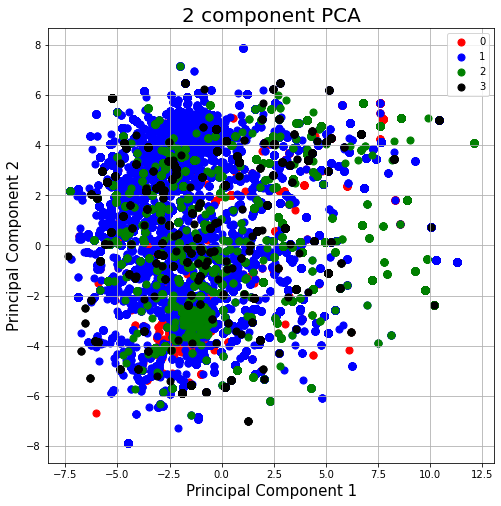

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2,3] #['benign', 'malicious']
colors = ['r',  'b', 'g', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

**Two Classes** **bold text**

In [ ]:
y_encoded = joblib.load("y_encoded4.joblib")
y= np.argmax(y_encoded, axis=1)
df['target'] = y  
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

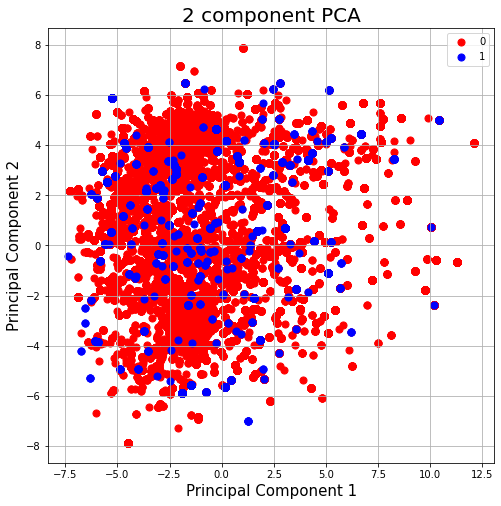

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1] #['benign', 'malicious']
colors = ['r',  'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# **Classifier - DATA IS TOO IMBALANCED FOR THIS TO WORK**
Before applying the classifier, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly.

**UMAP**

Out of the few dimensionality reduction algorithms, UMAP is arguably the best performing as it keeps a significant portion of the high-dimensional local structure in lower dimensionality.
Install the package with pip install umap-learn before we lower the dimensionality of the document embeddings. We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15. You can play around with these values to optimize for your topic creation. Note that a too low dimensionality results in a loss of information while a too high dimensionality results in poorer clustering results.

In [ ]:
# crashing...
#import umap
#umap_embeddings = umap.UMAP(n_neighbors=15, 
#                            n_components=5, 
#                           metric='cosine').fit_transform(embeddings)

In [ ]:
from sklearn.model_selection import train_test_split
embeddings = joblib.load("embeddings2.joblib")
y_encoded = joblib.load("y_encoded2.joblib")
X = np.array(embeddings)
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.seed(7))
input_dim = X_train.shape[1]
n_classes = y.shape[1]

In [ ]:
list(np.argmax(y_train, axis=1)).count(1)

8433

In [ ]:
from sklearn.utils import resample
# Separate majority and minority classes
df = pd.DataFrame(X_train)
y = np.argmax(y_train, axis=1)
df['balance'] = y

df_majority = df[df.balance==0]
df_minority = df[df.balance==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=8433,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.balance.value_counts()
# 1    73652
# 0    73652
# Name: balance, dtype: int64

1    8433
0    8433
Name: balance, dtype: int64

In [ ]:
y=np.array(df_downsampled.balance)
df_downsampled.drop('balance', axis=1, inplace=True)

In [ ]:
X_train = np.array(df_downsampled)
y_train = to_categorical(y)

In [ ]:
X_train.shape

(16866, 768)

In [ ]:
del embeddings
del y_encoded
del X
del y

NameError: ignored

In [ ]:
# define baseline model
def baseline_model(dim,n_classes):
	# create model
    model = Sequential()
    model.add(Dense(56, activation='relu', input_dim=dim))
    model.add(Dropout(0.1))
    model.add(Dense(28, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
    return model

In [ ]:
# Create callbacks
multi_checkpointer = ModelCheckpoint(filepath='weights.best.hdf5',verbose=2, save_best_only=True)
multi_lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=50, verbose=2, factor=0.2)
multi_earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=150, verbose=0, mode='auto')

In [ ]:
y_train.shape

(16866, 2)

In [ ]:
model = baseline_model(input_dim, n_classes)
model.summary()
# Train  model
history = model.fit(X_train, y_train,validation_split=0.1, epochs=150, batch_size=64, verbose=1, shuffle=True,
                                    callbacks=[multi_checkpointer,multi_lr_reduction,multi_earlystop])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 56)                43064     
_________________________________________________________________
dropout_8 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 28)                1596      
_________________________________________________________________
dropout_9 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 58        
Total params: 44,718
Trainable params: 44,718
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
223/238 [===========================>..] - ETA: 0s - loss: 0.2474 - accuracy: 0.8896
Epoch 00001: val_los

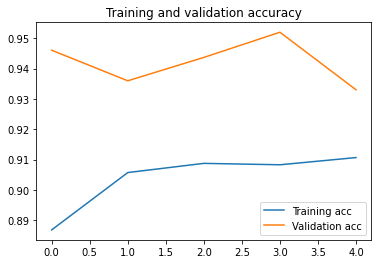

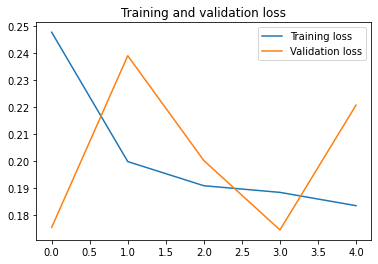

<Figure size 432x288 with 0 Axes>

In [ ]:
def visualize_performace(history):
    import matplotlib.pyplot as plt

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    plt.savefig('training.pdf')
    # plot model performance curves
visualize_performace(history)

#**Performance Metrics**

Baseline Accuracy: 88.55% 

16008/16008 [==============================] - 11s 700us/step


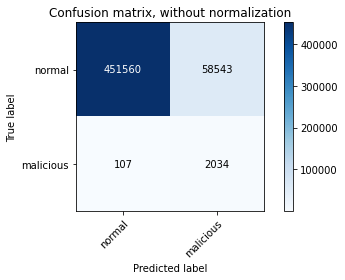

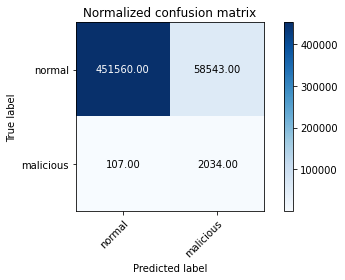

KeyError: ignored

In [ ]:
import Netflow_NN as NN
import matplotlib.pyplot as plt
# Load test data
# load best  weights checkpoint in HDF5
loaded_model = load_model("weights.best.hdf5")

class_size = 2
if class_size == 2:
   labels = ['normal','malicious']
else:
   labels = [0, 1, 2, 3]
n_classes = len(labels)

# --->Final evaluation of the model <----
scores = loaded_model.evaluate(X_test, y_test, verbose=0)
print("Baseline Accuracy: %.2f%% \n" % (scores[1]*100))

"""
Section to compute and plot confusion matrix y_test vs y_pred
The higher the diagonal values of the confusion matrix the better, indicating
many correct predictions. The confusion matrix is used to evaluate accuracy of a 
classification
"""
#---- > Compute confusion matrix <-----

np.set_printoptions(precision=5)
y_pred = loaded_model.predict(X_test, verbose=1)

# Plot non-normalized confusion matrix
NN.y_test = y_test
NN.y_pred = y_pred
NN.plot_confusion_matrix(NN.y_test, NN.y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
NN.plot_confusion_matrix(y_test, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
#------>End Final Evaluation of model <-----

#----> Plot ROC curves for the multiclass problem <----
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_size):
    fpr[i], tpr[i], _ = NN.roc_curve(NN.y_test[:, i], NN.y_pred[:, i])
    roc_auc[i] = NN.auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["macro"], tpr["macro"], _ = NN.roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["macro"] = NN.auc(fpr["macro"], tpr["macro"])
NN.Multi_ROC(class_size,fpr)

In [ ]:
y_pred

array([[8.19245e-01, 1.80755e-01],
       [9.99978e-01, 2.18691e-05],
       [4.84841e-01, 5.15159e-01],
       ...,
       [9.99798e-01, 2.02528e-04],
       [9.88856e-01, 1.11444e-02],
       [9.99798e-01, 2.02529e-04]], dtype=float32)

# Create Topics
We use the **distilbert-base-nli-mean-tokens** model as it is the recommended model for creating sentence embeddings according to the authors of the [sentence-embeddings](https://www.sbert.net/docs/pretrained_models.html) package. However, you can use whatever embeddings is currently pre-trained in the package.

In [ ]:
model = BERTopic("distilbert-base-nli-mean-tokens", verbose=True)
topics = model.fit_transform(docs)

In [ ]:
# Get most frequent topics
model.get_topics_freq()[:5]

In [ ]:
# Get a topic 
model.get_topic(22)[:10]

## Model serialization
The model and its internal settings can easily be saved. Note that the documents and embeddings will not be saved. However, UMAP and HDBSCAN will be saved. 

In [ ]:
# Save model
model.save("my_model")	

In [ ]:
# Load model
my_model = BERTopic.load("my_model")	

In [ ]:
my_model.get_topic(4)[:10]